In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Анализ данных

## Загрузка данных

In [2]:
train_path = 'train.csv'

train_data = pd.read_csv(train_path)

## Описание данных

In [3]:
len(train_data)

16000

In [4]:
train_data.head()

,index,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,0,495.67,17.0,1,22,0,1,0.0,0.0,185.18,287.05,0.85,6.33,54.38,0.0,0.0,0.00,30.54,0.0,509.94
1,1,595.67,21.0,1,32,0,1,0.0,0.0,76.28,522.28,0.00,7.96,190.97,0.0,0.0,0.00,0.00,0.0,606.52
2,2,786.37,10.0,1,45,1,2,0.0,0.0,131.27,566.15,0.00,20.23,328.13,0.0,0.0,8.85,0.00,0.0,726.50
3,3,1142.63,10.0,1,41,0,2,0.0,0.0,307.49,926.55,0.00,8.08,351.38,0.0,0.0,0.00,5.05,0.0,1247.17
4,4,567.47,19.0,1,36,0,1,0.0,0.0,4.18,529.77,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,533.95


In [5]:
train_data.describe()

,index,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
count,16000.000000,16000.00000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,16000.0,16000.000000,16000.000000,16000.000000,16000.000000
mean,7999.500000,471.28077,15.169750,0.750750,32.961188,0.196500,1.179938,191.381912,0.0,52.460246,278.174804,0.069534,7.280819,166.824287,0.0,0.0,0.454579,1.107541,0.577436,340.702423
std,4618.946489,393.65383,4.184603,0.432592,8.948425,0.397363,0.571582,399.199579,0.0,81.209825,253.285298,0.410552,33.254749,216.672893,0.0,0.0,2.885566,8.401314,7.188730,306.372223
min,0.000000,6.25000,10.000000,0.000000,19.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,3.900000
25%,3999.750000,208.43500,11.000000,1.000000,26.000000,0.000000,1.000000,0.000000,0.0,9.130000,105.020000,0.000000,0.000000,33.900000,0.0,0.0,0.000000,0.000000,0.000000,134.395000
50%,7999.500000,362.87500,15.000000,1.000000,32.000000,0.000000,1.000000,59.290000,0.0,26.895000,209.825000,0.000000,0.050000,95.350000,0.0,0.0,0.000000,0.000000,0.000000,256.280000
75%,11999.250000,593.59750,18.000000,1.000000,38.000000,0.000000,1.000000,262.212500,0.0,63.190000,371.340000,0.000000,2.290000,217.472500,0.0,0.0,0.000000,0.000000,0.000000,446.172500
max,15999.000000,2714.44000,23.000000,1.000000,60.000000,1.000000,17.000000,17023.760000,0.0,1455.440000,2502.370000,11.400000,977.570000,2615.740000,0.0,0.0,112.230000,448.880000,599.950000,2939.220000


В тренировочном наборе признаки x7, x13 и x14 состоят только из нулей, что указывает на их особенность. В дальнейшем мы можем исключить их из рассмотрения. Однако от столбца `index` удобно избавиться уже сейчас.

In [6]:
train_data = train_data.drop(columns=['index'])

## Визуализация данных

In [7]:
def visualize_histogram(train_data, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_data[feature_name])
    plt.title(f'Гистограмма признака {feature_name}')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()

def visualize_boxplot(train_data, feature_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train_data[feature_name])
    plt.title(f'Коробчатая диаграмма для признака {feature_name}')
    plt.show()

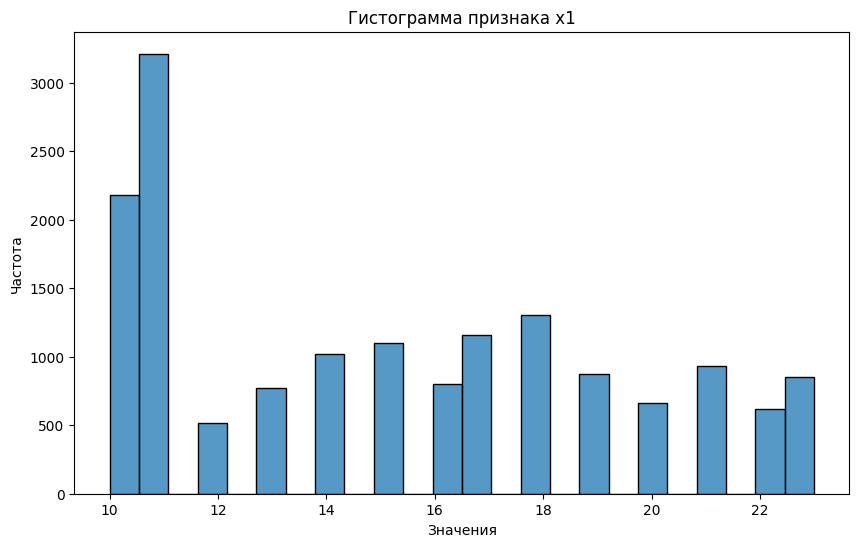

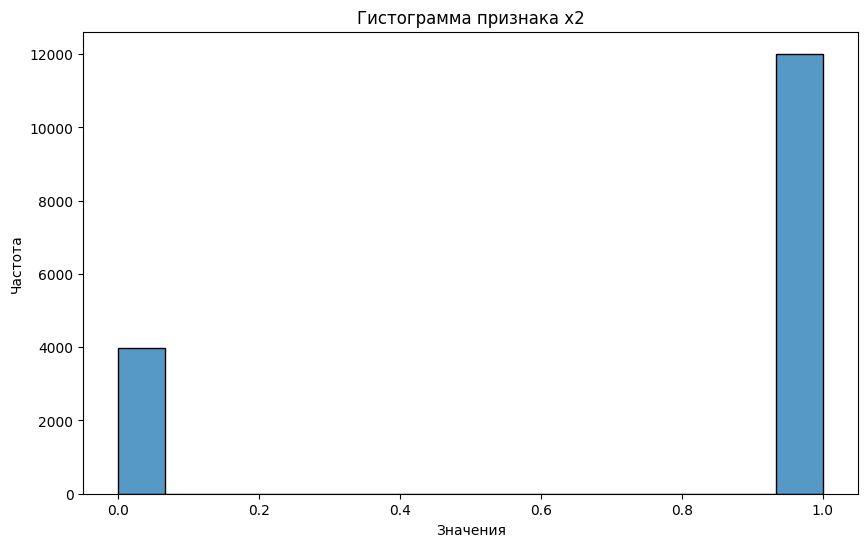

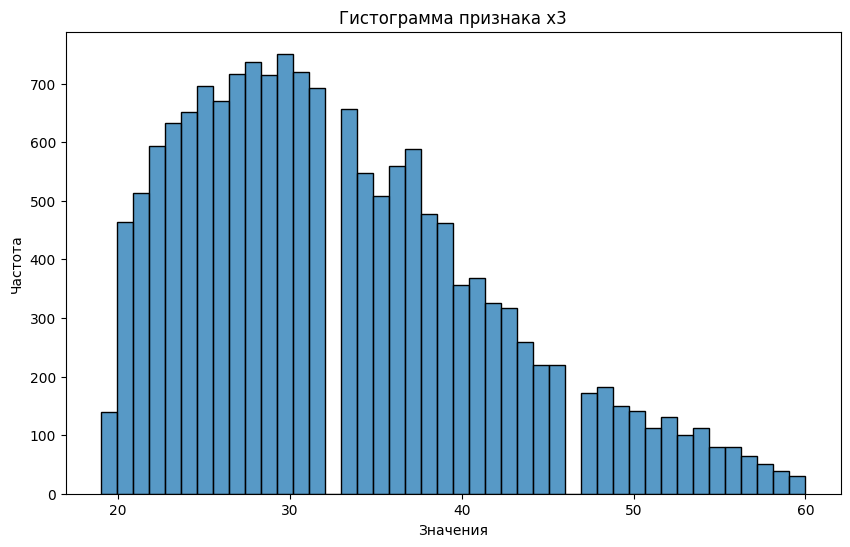

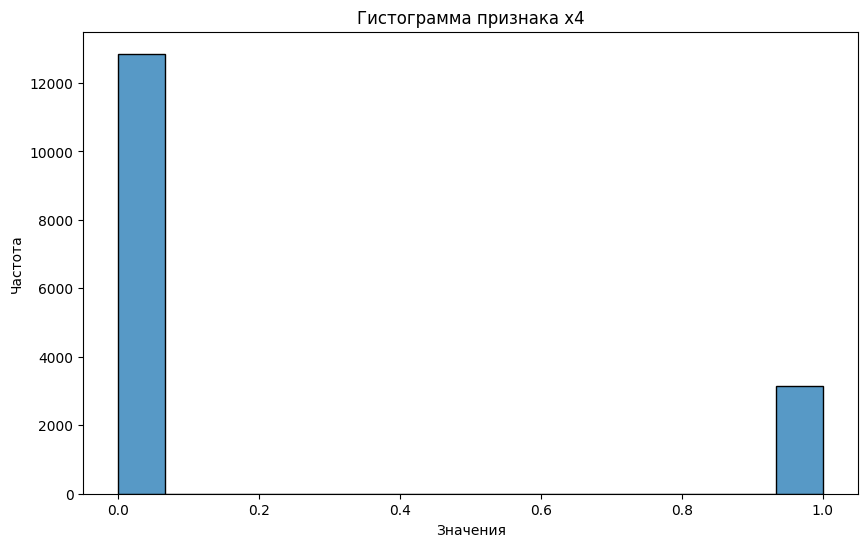

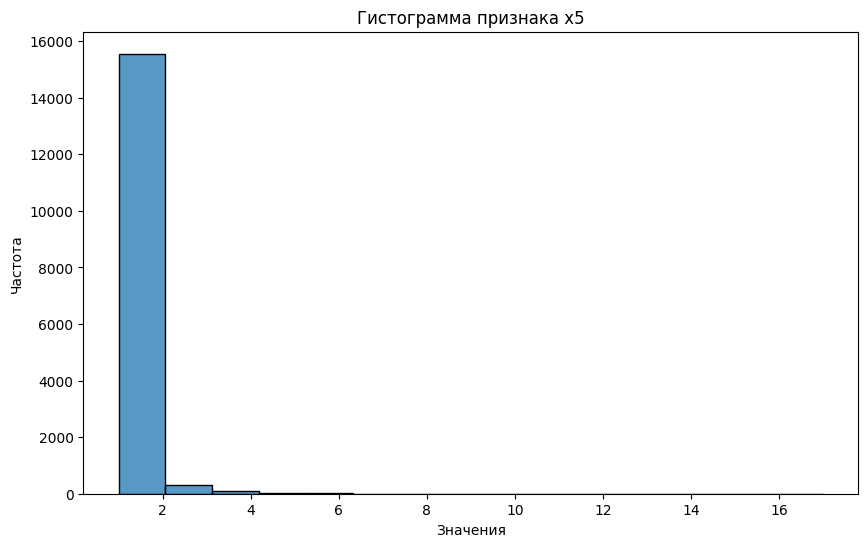

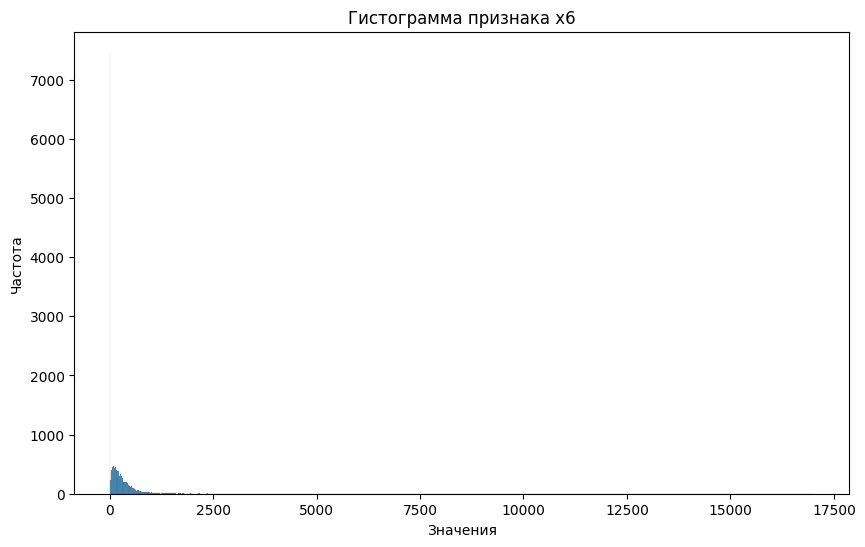

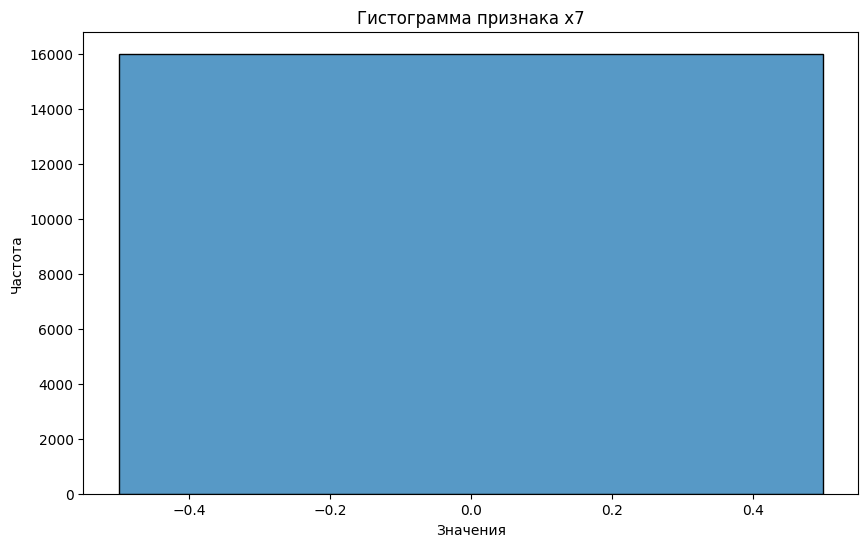

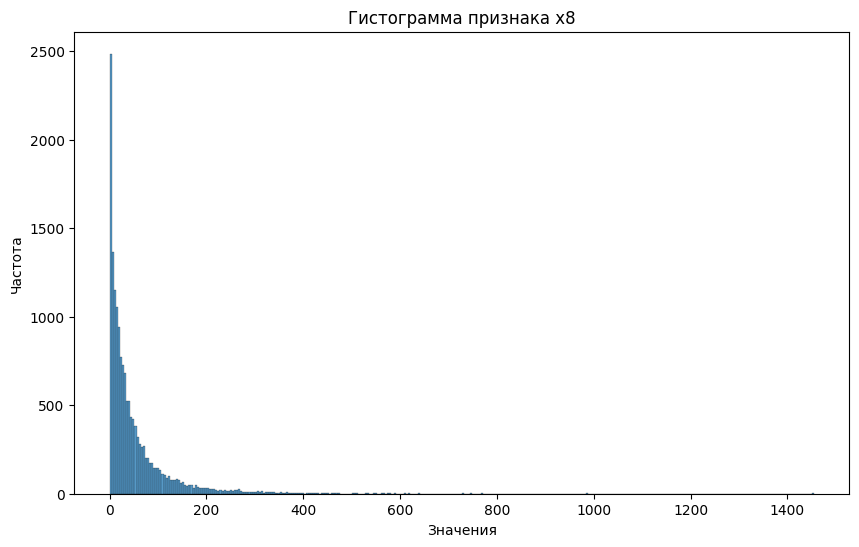

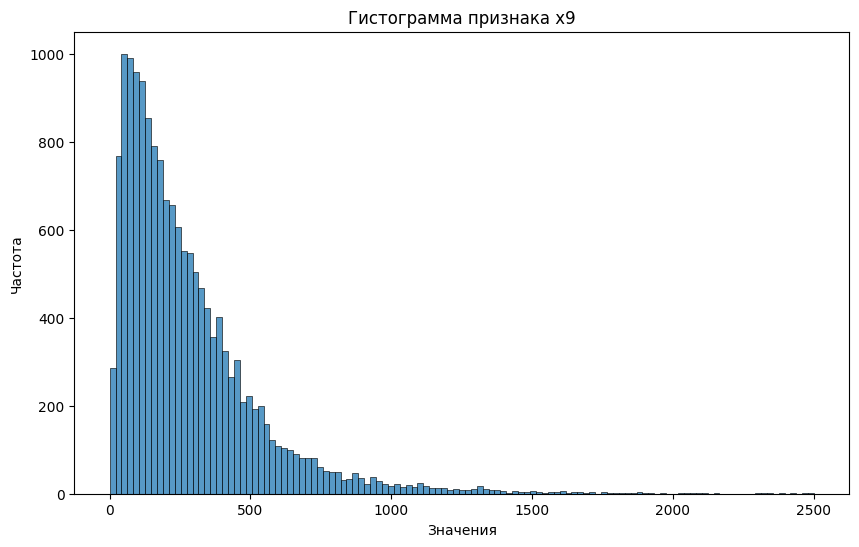

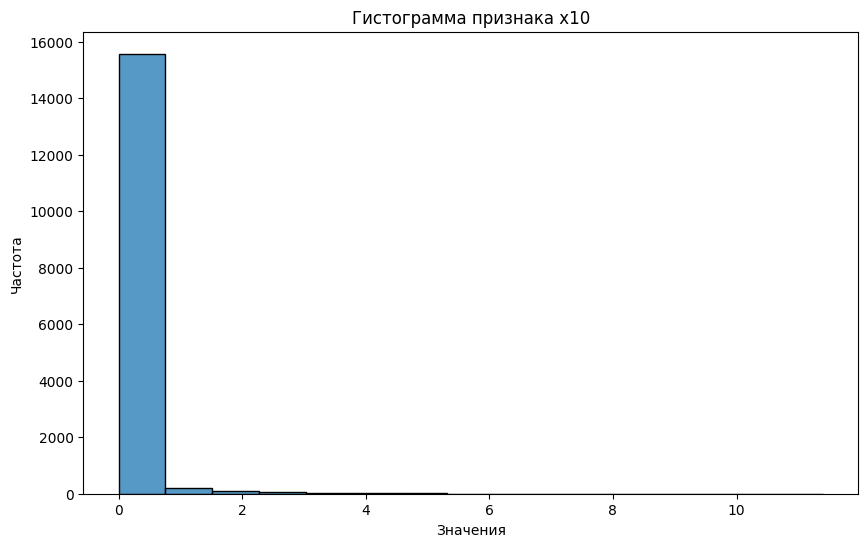

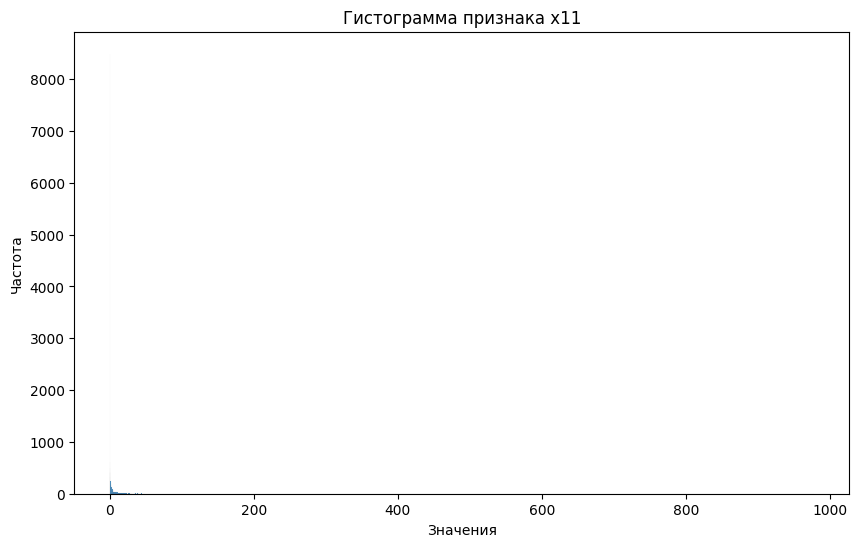

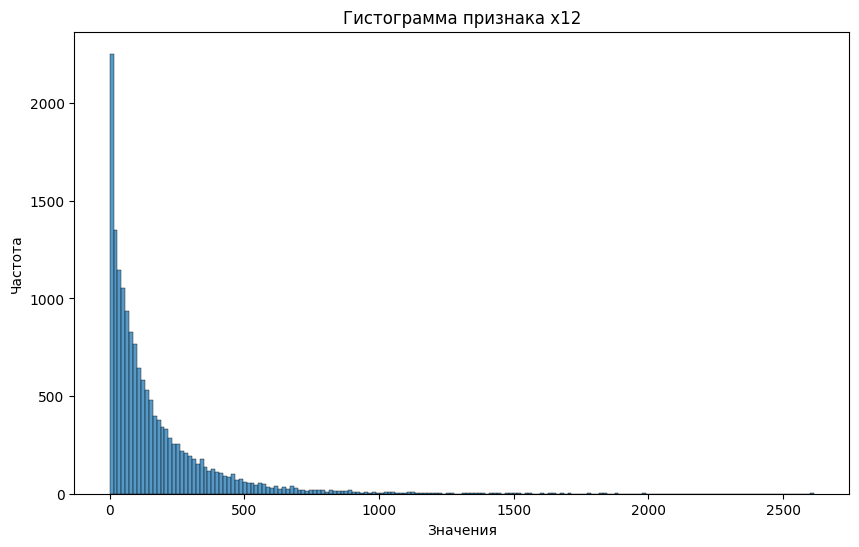

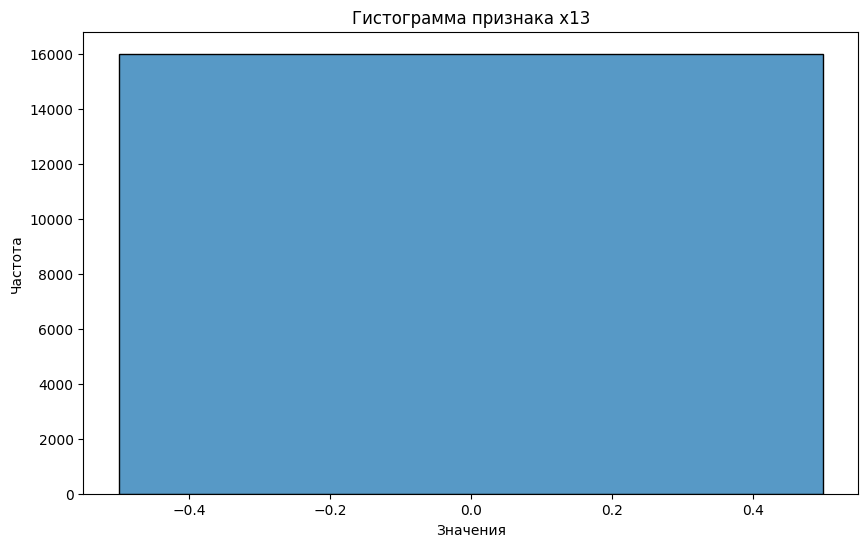

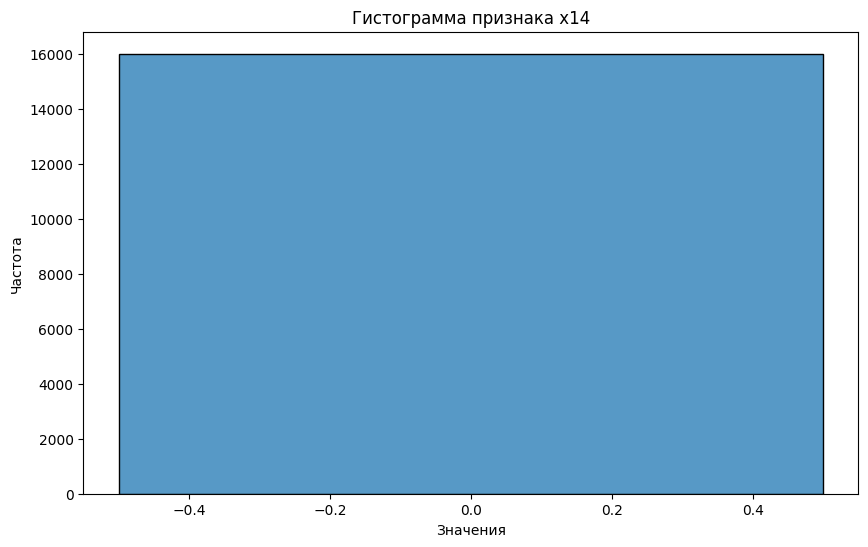

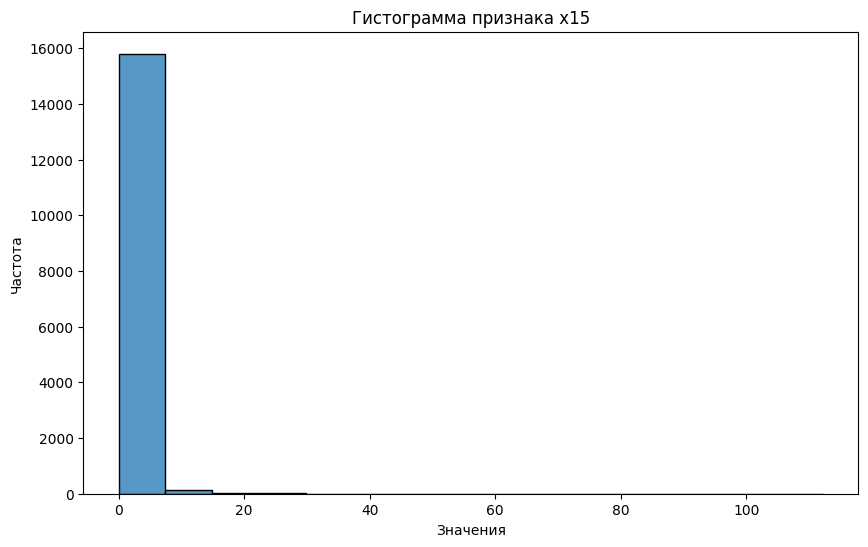

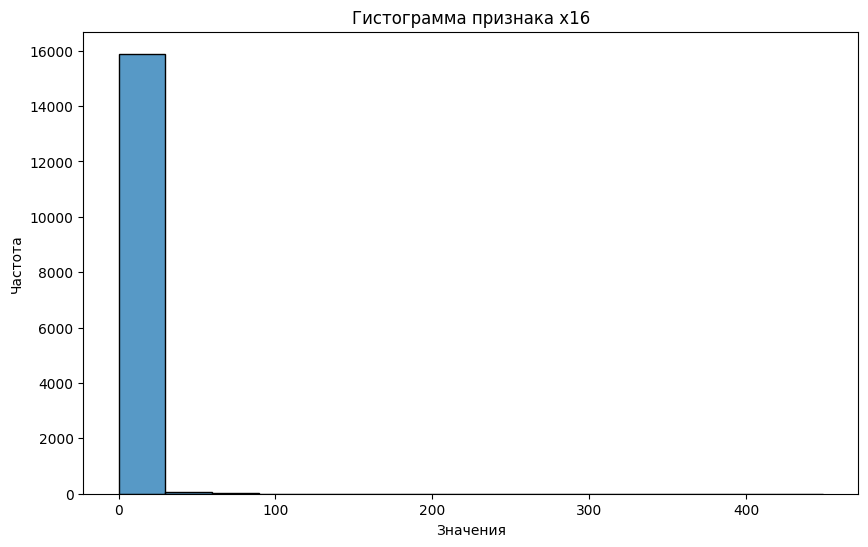

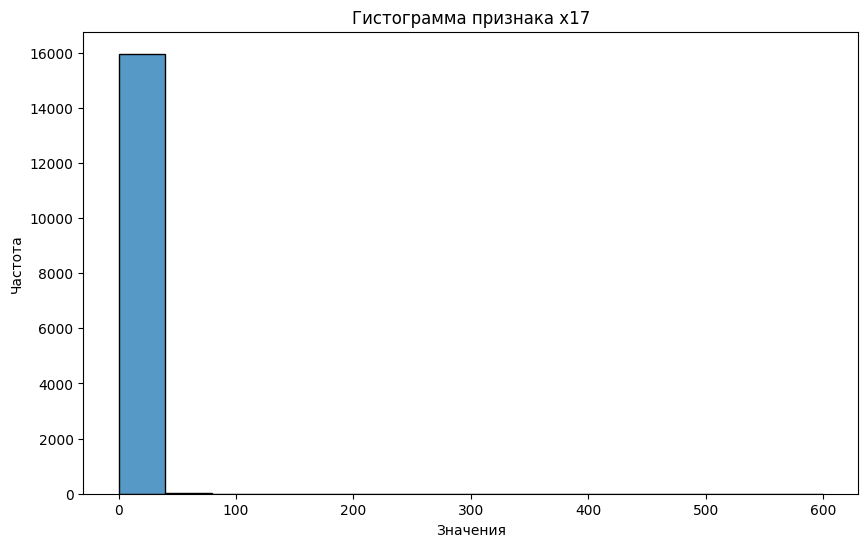

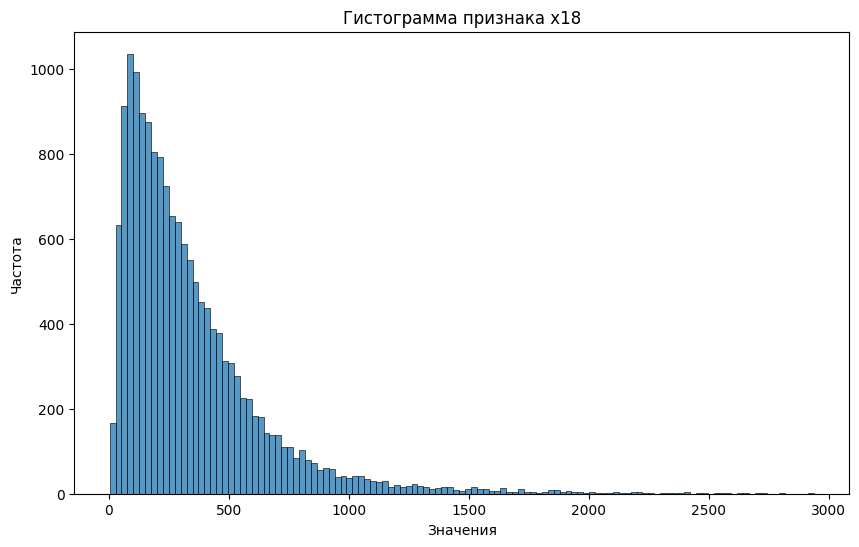

In [8]:
for feature_name in train_data.columns:
    if feature_name == 'y':
        continue
    visualize_histogram(train_data, feature_name)

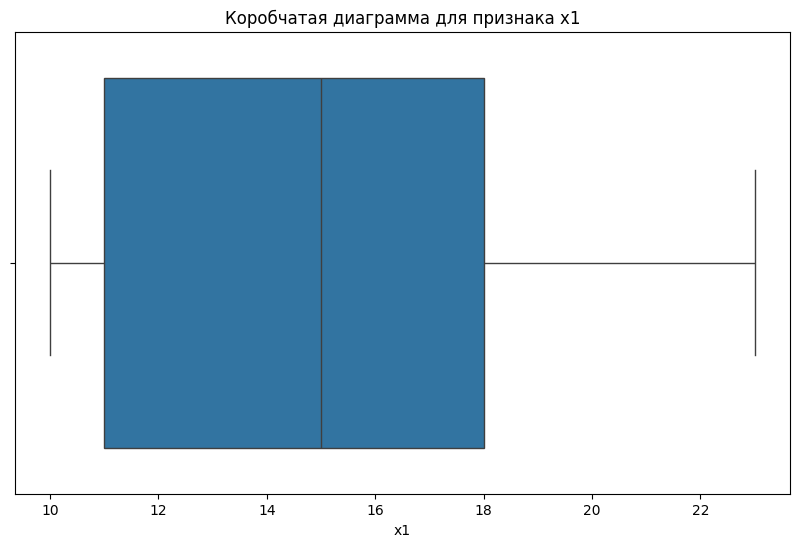

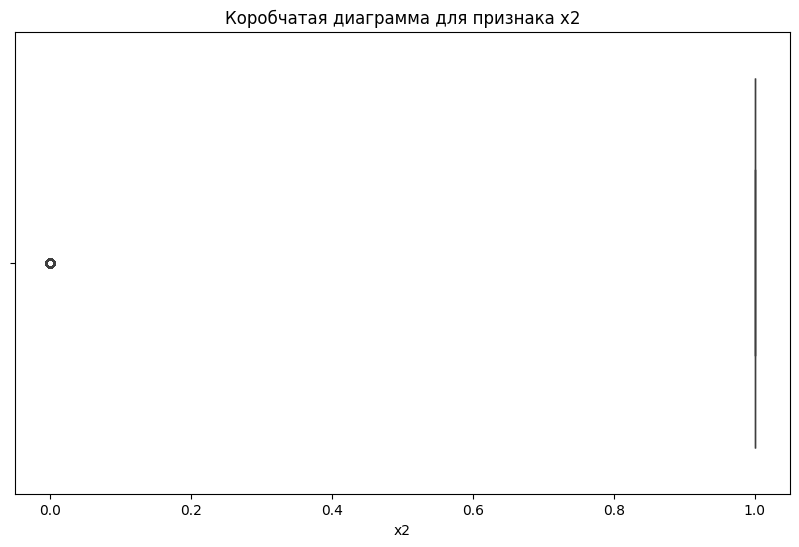

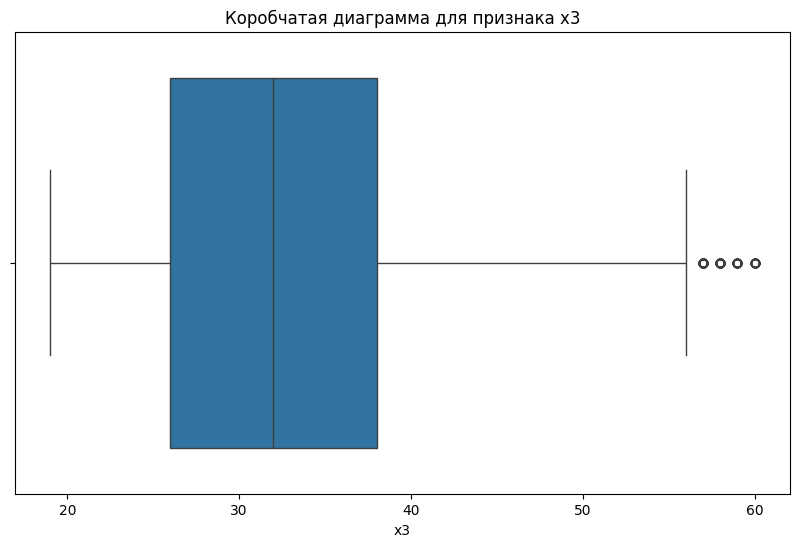

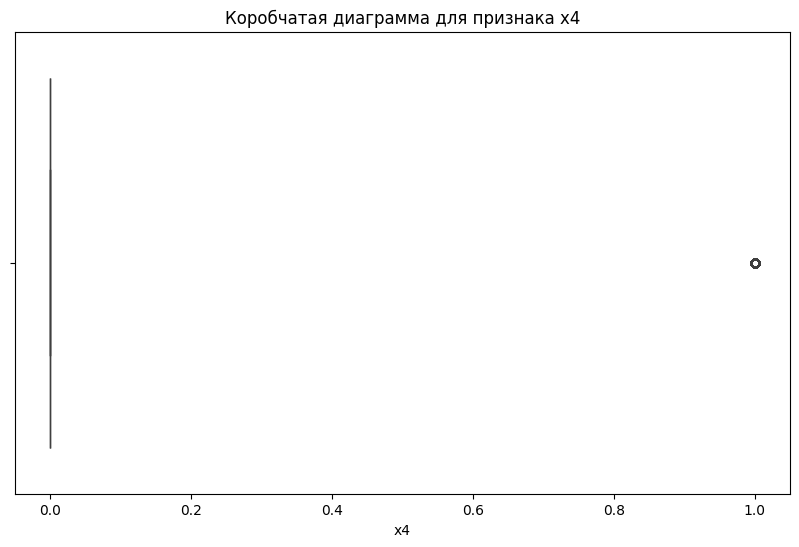

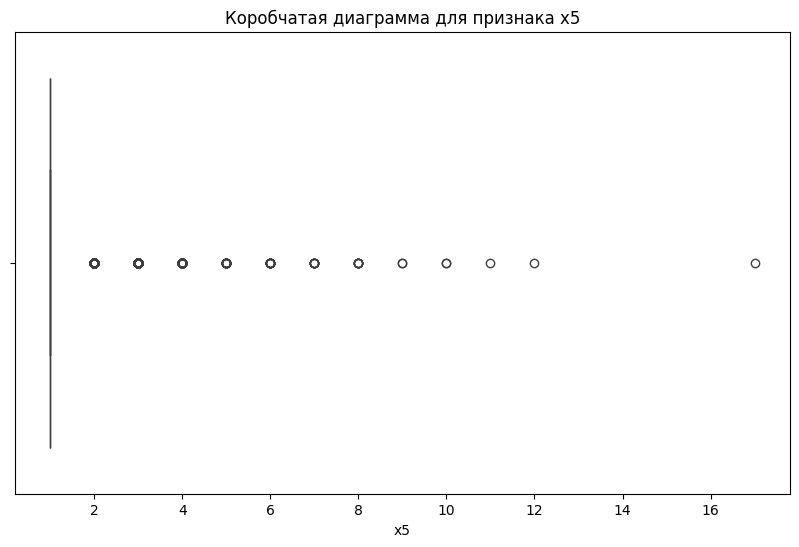

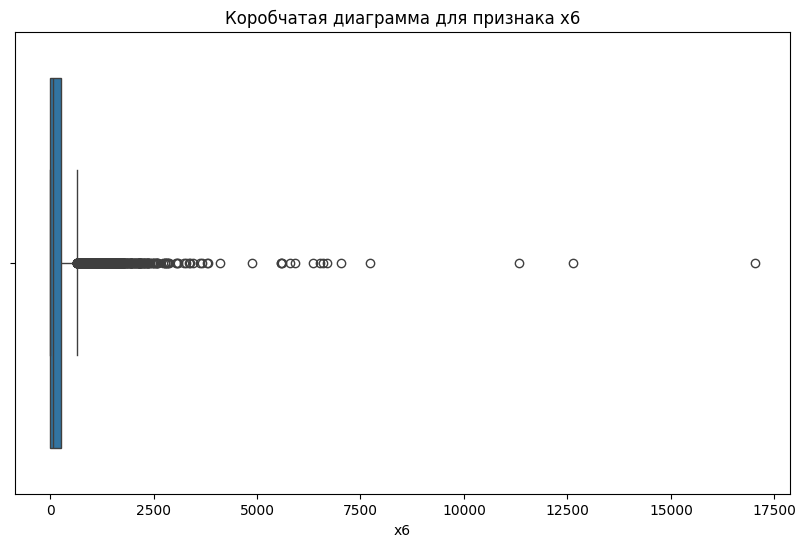

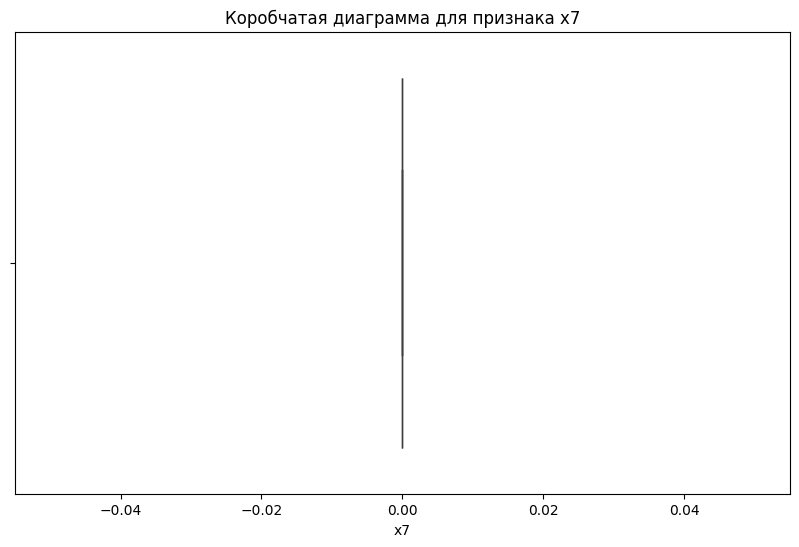

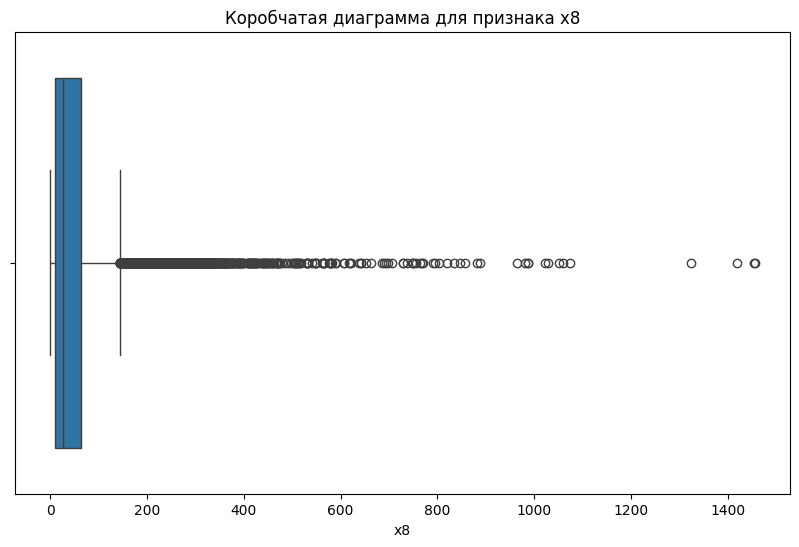

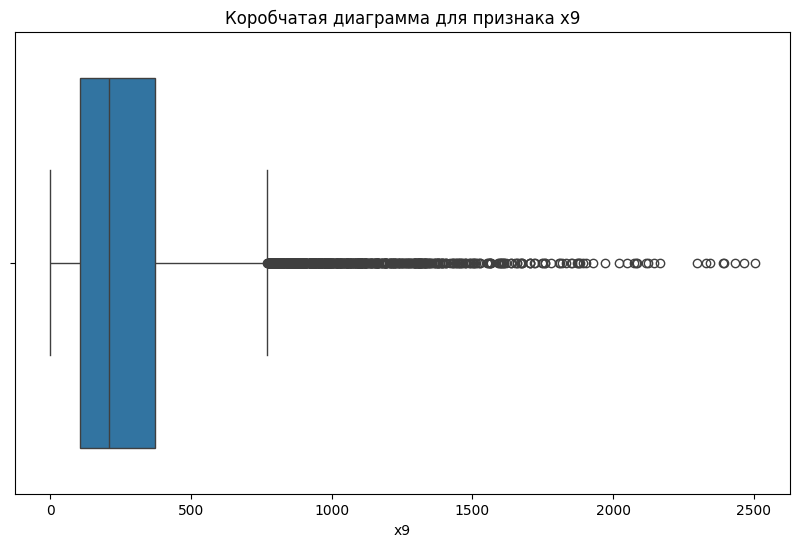

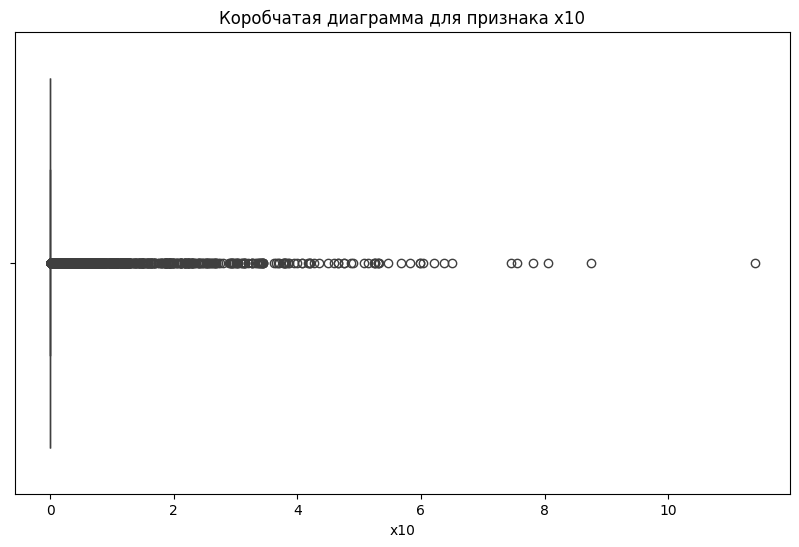

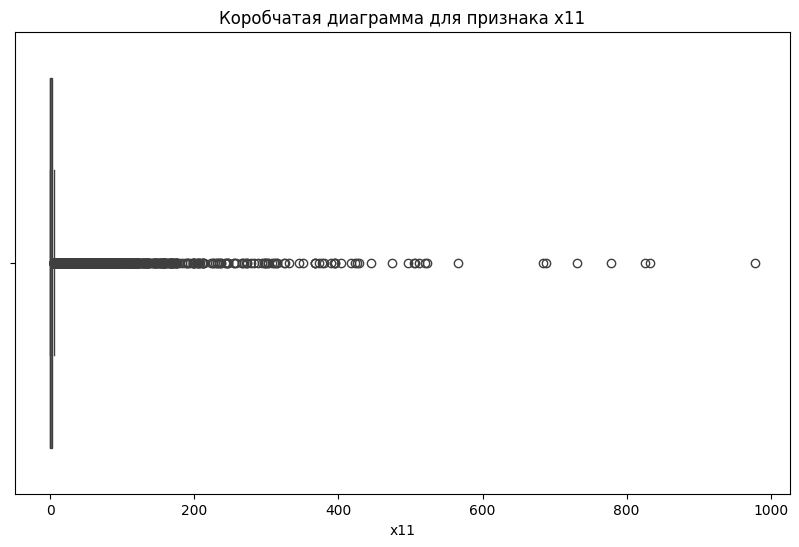

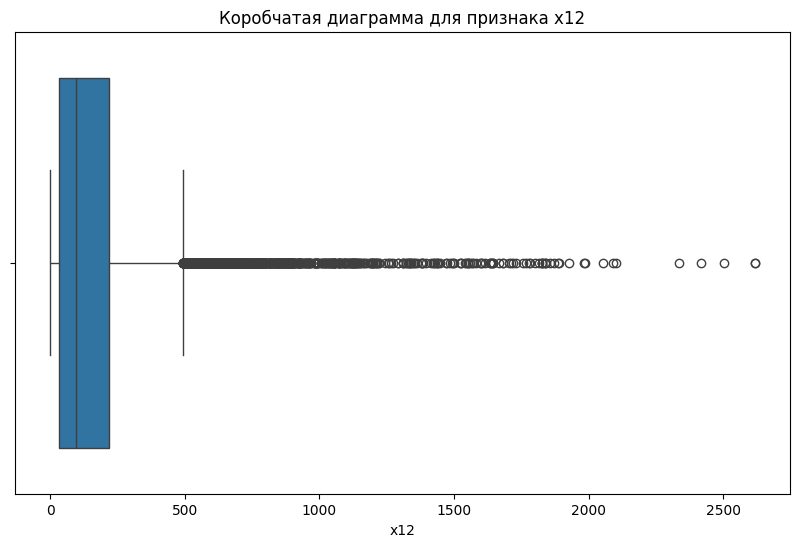

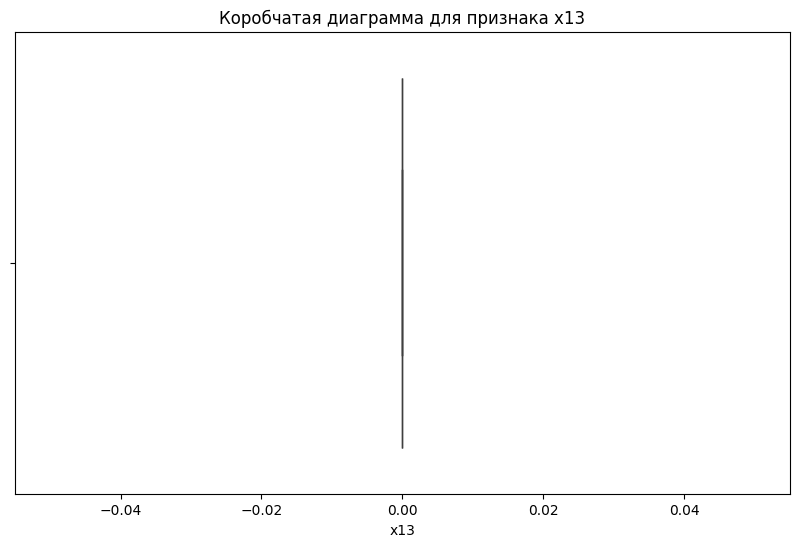

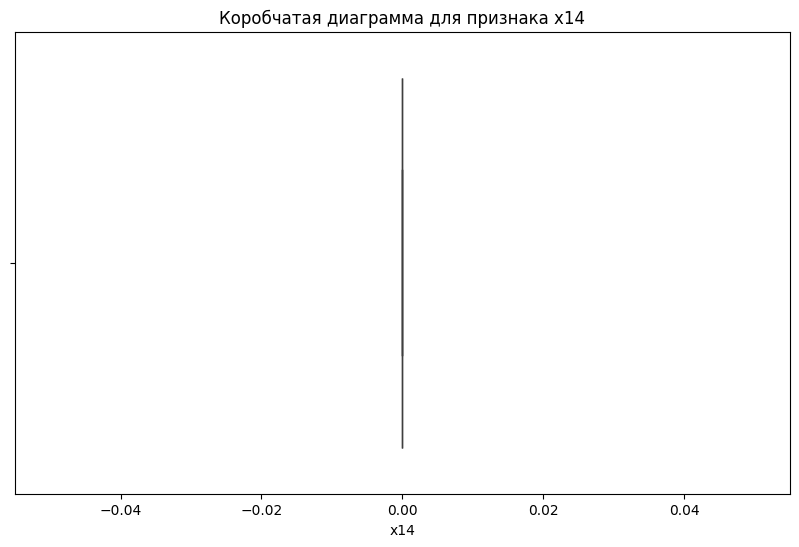

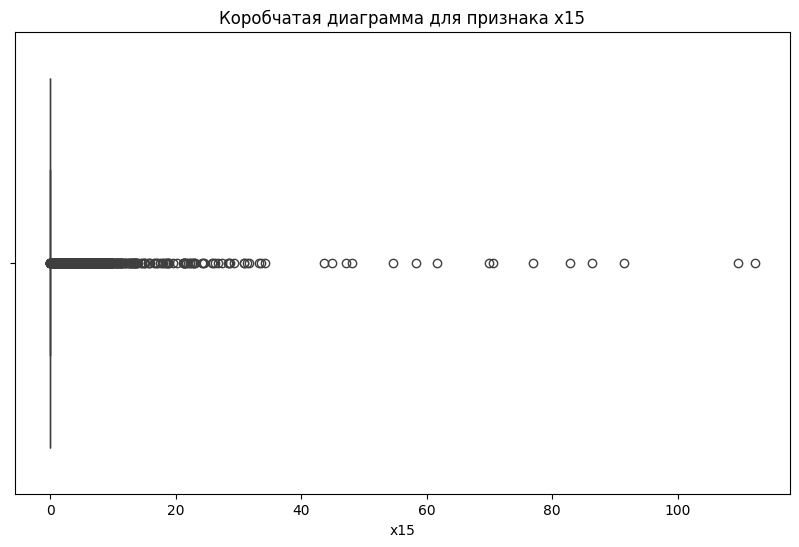

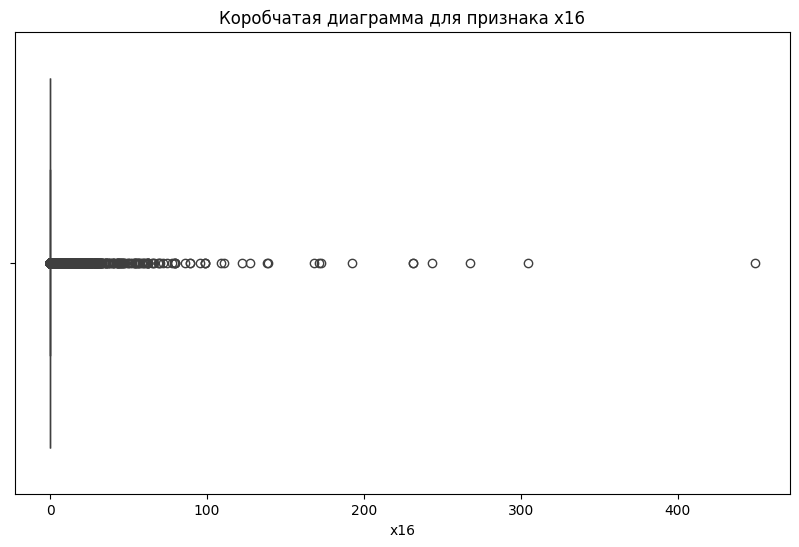

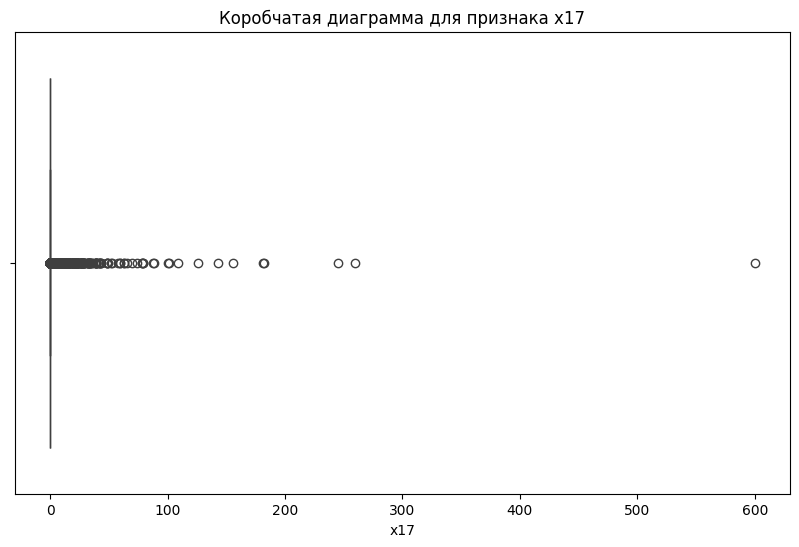

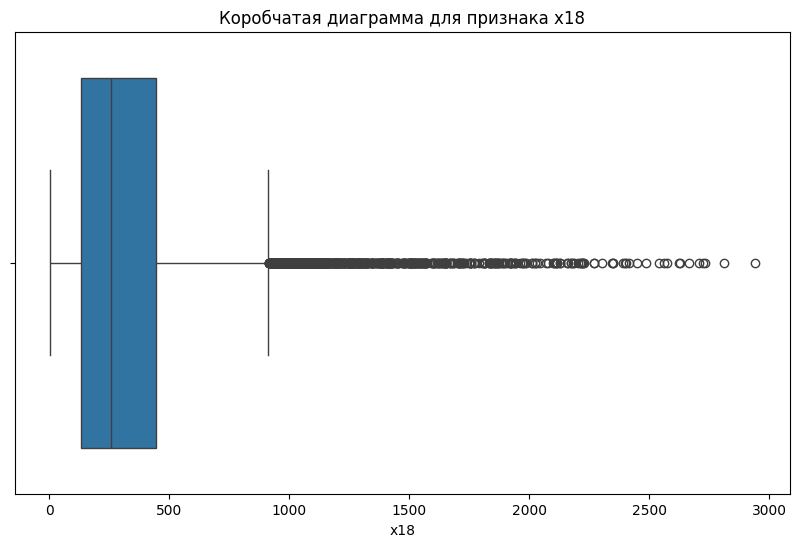

In [9]:
for feature_name in train_data.columns:
    if feature_name == 'y':
        continue
    visualize_boxplot(train_data, feature_name)

# Модель

In [10]:
class BaseModel(object):
    def __init__(self):
        self.quality_metric = mean_absolute_percentage_error
        self.coefs = None

    def empirical_risk(self, coefs, X, Y):
        raise NotImplementedError('Метод empirical_risk должен быть переопределен в подклассе.')

    def fit(self, X, Y):
        X = X.values
        Y = Y.values

        initial_coefs = np.zeros(X.shape[1] + 1)
        
        res = scipy.optimize.minimize(self.empirical_risk, initial_coefs, args=(X, Y))
        self.coefs = res.x

        return self

    def predict(self, X):
        if self.coefs is None:
            raise ValueError('Модель не обучена. Сначала вызовите метод fit.')
        return np.dot(X, self.coefs[1:]) + self.coefs[0]

    def test_on_dataset(self, X_test, Y_test):
        assert len(X_test) == len(Y_test), 'Количество объектов в X_test и Y_test должно совпадать.'
        y_pred = self.predict(X_test)
        return self.quality_metric(Y_test, y_pred)

In [11]:
class M1(BaseModel):
    def __init__(self):
        super().__init__()

    def empirical_risk(self, coefs, X, Y):
        Y_pred = np.dot(X, coefs[1:]) + coefs[0]
        return self.quality_metric(Y, Y_pred)

# Исследование на тестовых данных

In [12]:
def func(train_data):
    X = train_data.drop(columns=['y'])
    Y = train_data['y']

    model = M1()
    model.fit(X, Y)

    score = model.test_on_dataset(X, Y)
    print(f'Score: {score:.4f}')

## 1. Обучим модель на необработанных данных:

In [13]:
train_data_1 = train_data.copy()
func(train_data_1)

Score: 0.2425


## 2. Удалим из данных 'нулевые' признаки x7, x13 и x14:

In [14]:
def delete(data):
    data = data.drop(columns=['x7', 'x13', 'x14'])
    return data

In [15]:
train_data_2 = train_data.copy()

In [16]:
train_data_2 = delete(train_data_2)

In [17]:
func(train_data_2)

Score: 0.2424


## 3. Нормализуем признак x6:

In [18]:
def normalize_x6(data, debug=False):
    if debug:
        print('Начальное распределение:')
        visualize_histogram(data, 'x6')
        visualize_boxplot(data, 'x6')

    threshold = 1500
    data = data[data['x6'] <= threshold]

    if debug:
        print('Распределение после удаления выбросов:')
        visualize_histogram(data, 'x6')
        visualize_boxplot(data, 'x6')

    data = data[data['x6'] != 0]

    if debug:
        print('Распределение после удаления нулевых значений:')
        visualize_histogram(data, 'x6')
        visualize_boxplot(data, 'x6')

    return data

In [19]:
train_data_3 = train_data.copy()

In [21]:
freq = {}
for x in train_data_3['x6']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 7355)


In [22]:
train_data_3 = normalize_x6(train_data_3)

In [23]:
func(train_data_3)

Score: 0.2404


## 4. Объеденим подпункты 2 и 3:

In [24]:
def delete_and_normalize_x6(data):
    data = delete(data)
    data = normalize_x6(data)
    return data

In [25]:
train_data_4 = train_data.copy()

In [26]:
train_data_4 = delete_and_normalize_x6(train_data_4)

In [27]:
func(train_data_4)

Score: 0.2402


## 5. Нормализуем признак x8:

In [28]:
def normalize_x8(data, debug=False):
    if debug:
        print('Начальное распределение:')
        visualize_histogram(data, 'x8')
        visualize_boxplot(data, 'x8')
    
    data = data[data['x8'] != 0]

    if debug:
        print('Распределение после удаления нулевых значений:')
        visualize_histogram(data, 'x8')
        visualize_boxplot(data, 'x8')

    return data

In [29]:
train_data_5 = train_data.copy()

In [31]:
freq = {}
for x in train_data_5['x8']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 465)


In [32]:
train_data_5 = normalize_x8(train_data_5)

In [33]:
func(train_data_5)

Score: 0.2400


## 6. Объеденим подпункты 2, 3 и 5:

In [34]:
def delete_normalize_x6_and_normalize_x8(data):
    data = delete(data)
    data = normalize_x6(data)
    data = normalize_x8(data)
    return data

In [35]:
train_data_6 = train_data.copy()

In [36]:
train_data_6 = delete_normalize_x6_and_normalize_x8(train_data_6)

In [37]:
func(train_data_6)

Score: 0.2367


## 7. Нормализуем признак x11:

In [38]:
def normalize_x11(data, debug=False):
    if debug:
        print('Начальное распределение:')
        visualize_histogram(data, 'x11')
        visualize_boxplot(data, 'x11')

    threshold = 500
    data = data[data['x11'] <= threshold]

    if debug:
        print('Распределение после удаления выбросов:')
        visualize_histogram(data, 'x11')
        visualize_boxplot(data, 'x11')
    
    data = data[data['x11'] != 0]

    if debug:
        print('Распределение после удаления нулевых значений:')
        visualize_histogram(data, 'x11')
        visualize_boxplot(data, 'x11')

    return data

In [39]:
train_data_7 = train_data.copy()

In [40]:
freq = {}
for x in train_data_7['x11']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 7804)


In [41]:
train_data_7 = normalize_x11(train_data_7)

In [42]:
func(train_data_7)

Score: 0.2255


## 8. Объеденим подпункты 2, 3, 5 и 7:

In [43]:
def delete_normalize_x6_x8_and_x11(data):
    data = delete(data)
    data = normalize_x6(data)
    data = normalize_x8(data)
    data = normalize_x11(data)
    return data

In [44]:
train_data_8 = train_data.copy()

In [45]:
train_data_8 = normalize_x11(train_data_8)

In [46]:
func(train_data_8)

Score: 0.2255


## 9. Нормализуем признак x12:

In [47]:
def normalize_x12(data, debug=False):
    if debug:
        print('Начальное распределение:')
        visualize_histogram(data, 'x12')
        visualize_boxplot(data, 'x12')

    threshold = 1500
    data = data[data['x12'] <= threshold]

    if debug:
        print('Распределение после удаления выбросов:')
        visualize_histogram(data, 'x12')
        visualize_boxplot(data, 'x12')
    
    data = data[data['x12'] != 0]

    if debug:
        print('Распределение после удаления нулевых значений:')
        visualize_histogram(data, 'x12')
        visualize_boxplot(data, 'x12')

    return data

In [49]:
train_data_9 = train_data.copy()

In [50]:
freq = {}
for x in train_data_9['x12']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 586)


In [51]:
train_data_9 = normalize_x12(train_data_9)

In [52]:
func(train_data_9)

Score: 0.2403


## 10. Объеденим подпункты 2, 3, 5, 7 и 9:

In [53]:
def delete_normalize_x6_x8_x11_and_x12(data):
    data = delete(data)
    data = normalize_x6(data)
    data = normalize_x8(data)
    data = normalize_x11(data)
    data = normalize_x12(data)
    return data

In [54]:
train_data_10 = train_data.copy()

In [55]:
train_data_10 = delete_normalize_x6_x8_x11_and_x12(train_data_10)

In [56]:
len(train_data_10)

4138

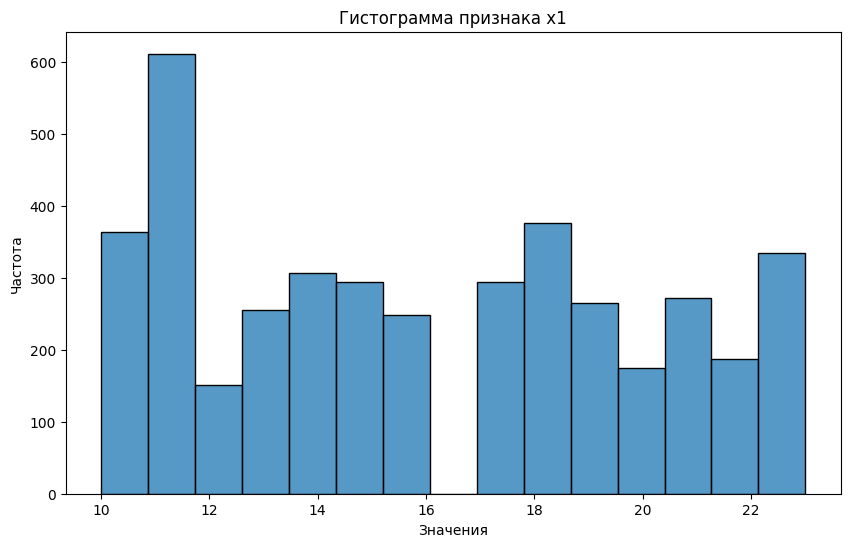

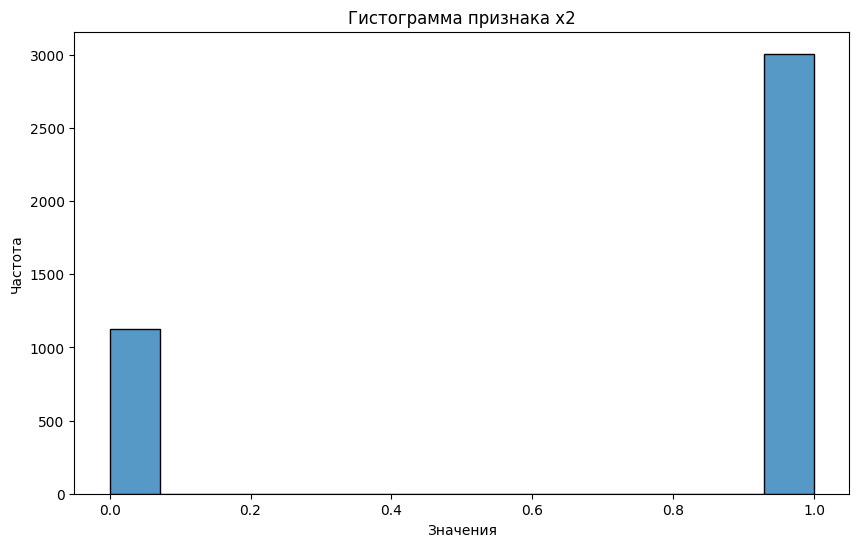

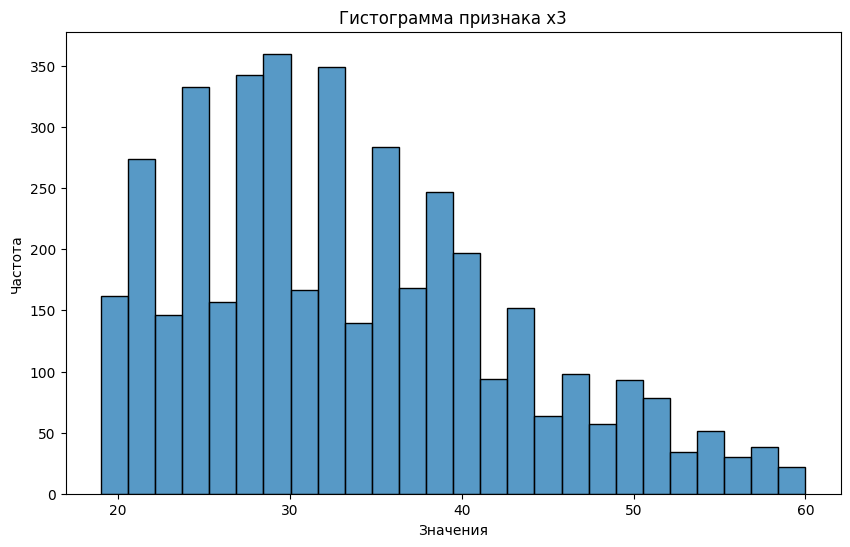

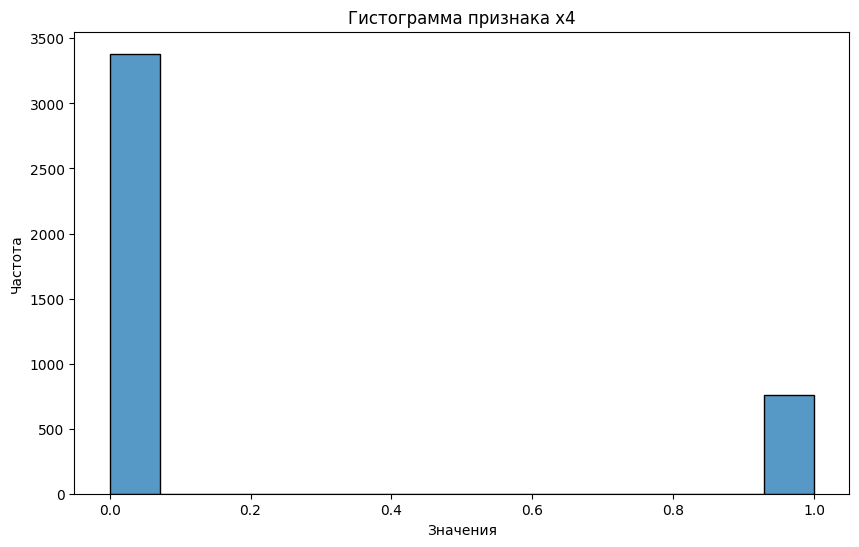

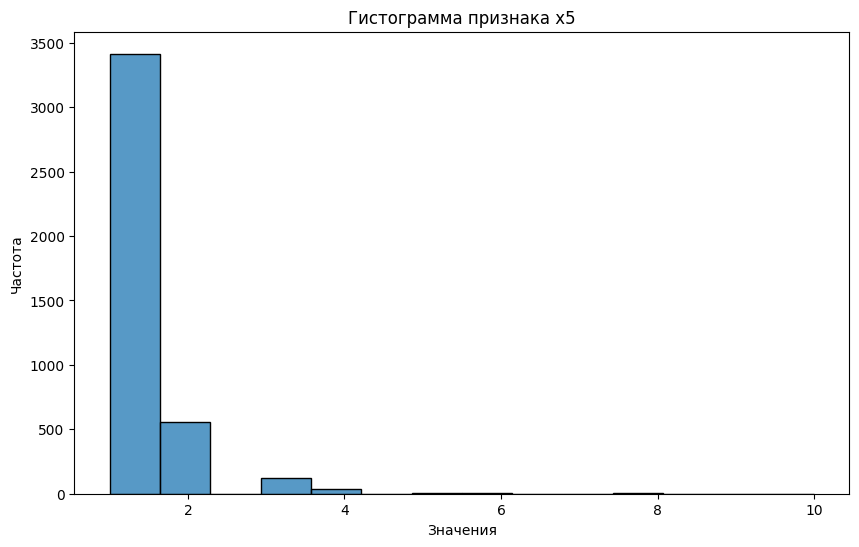

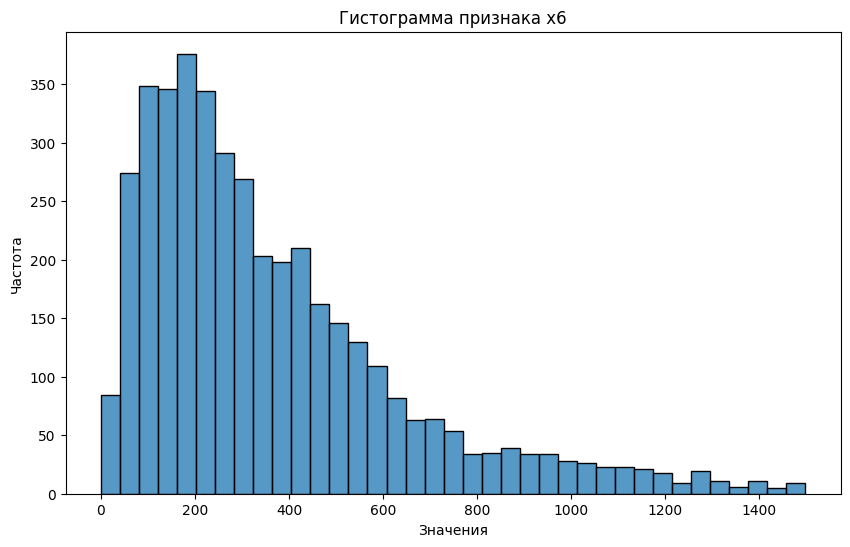

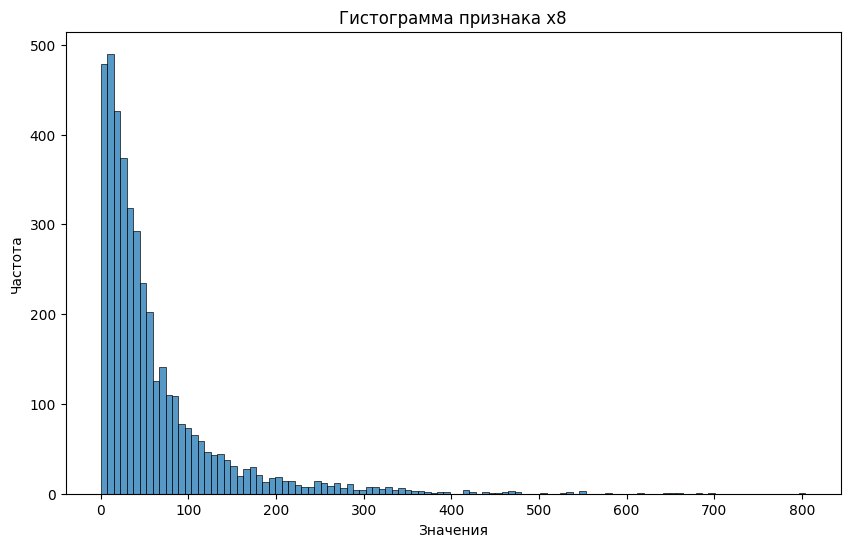

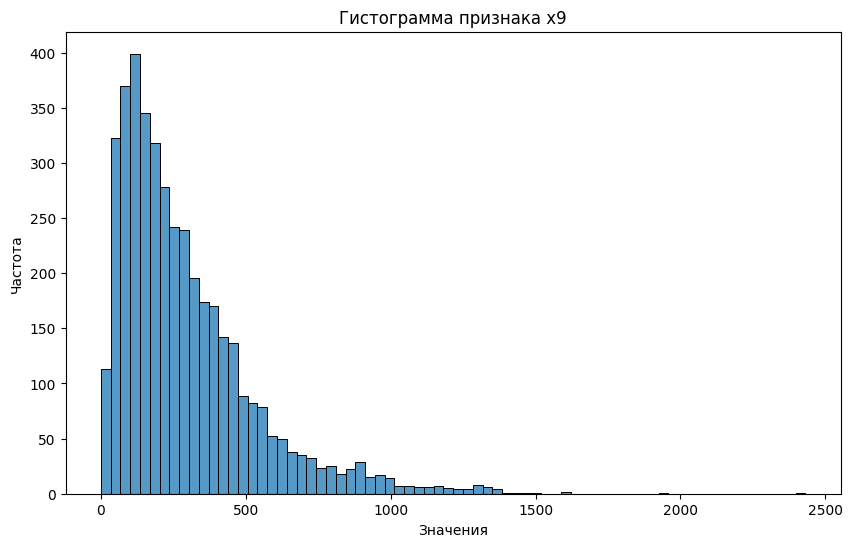

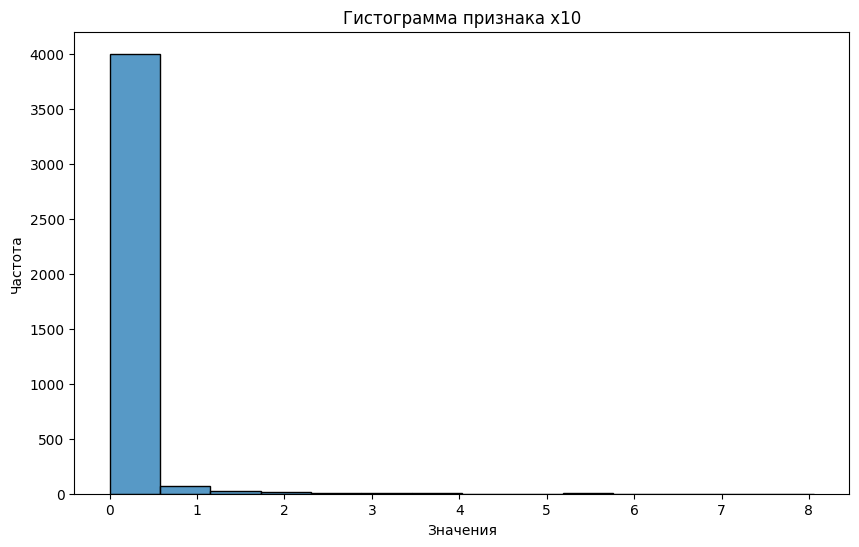

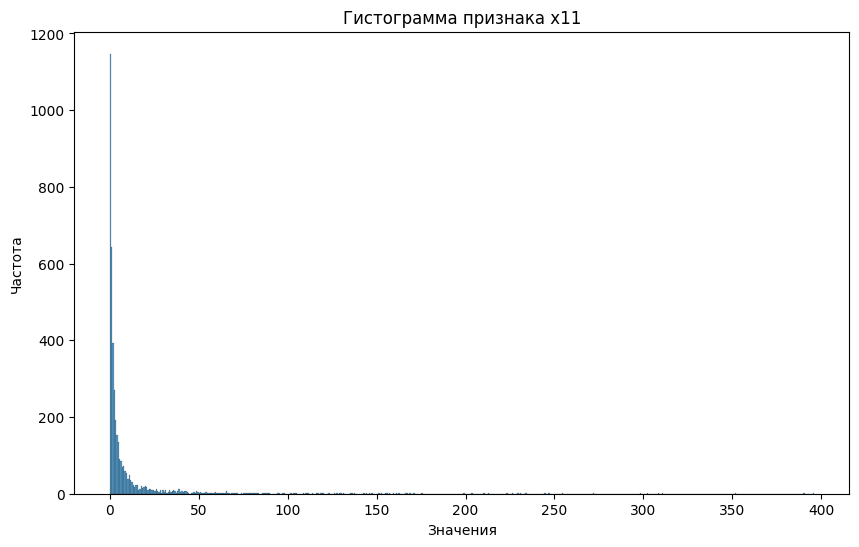

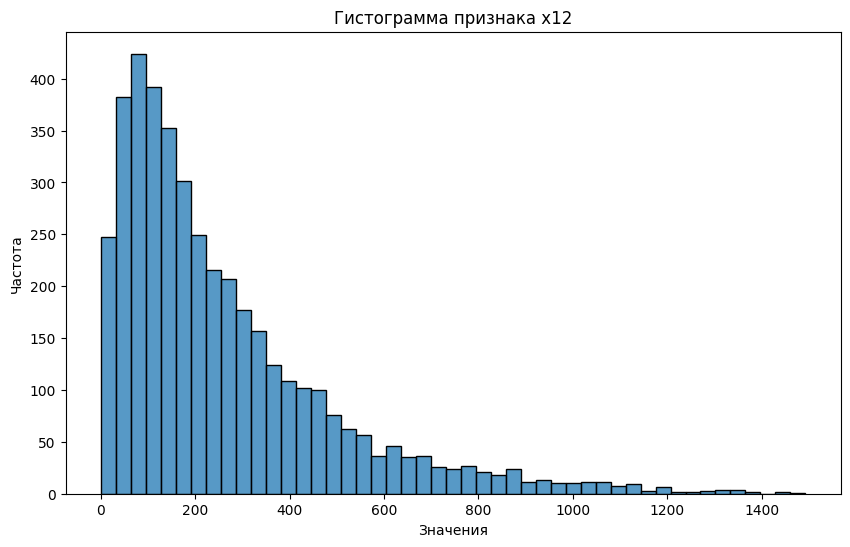

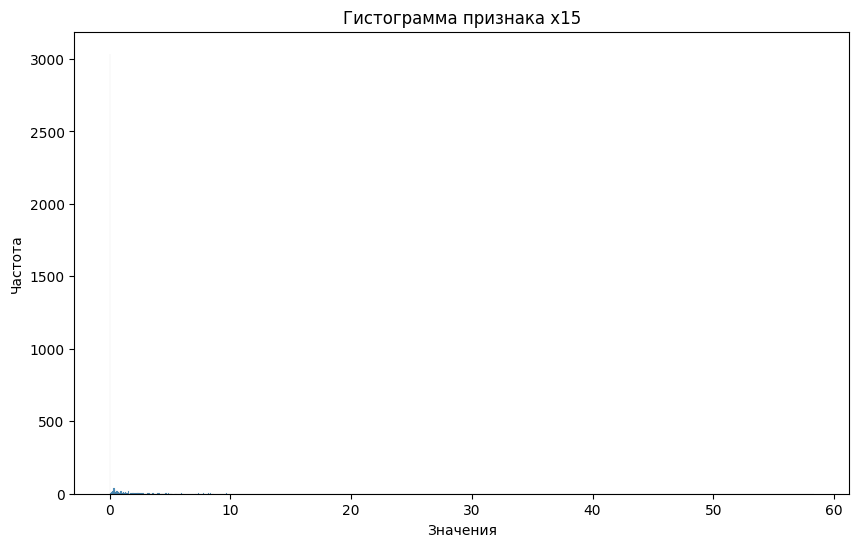

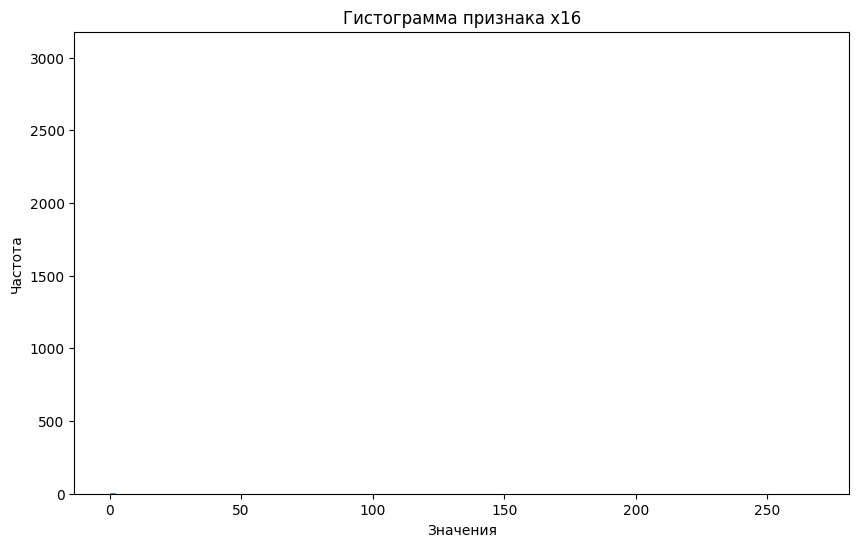

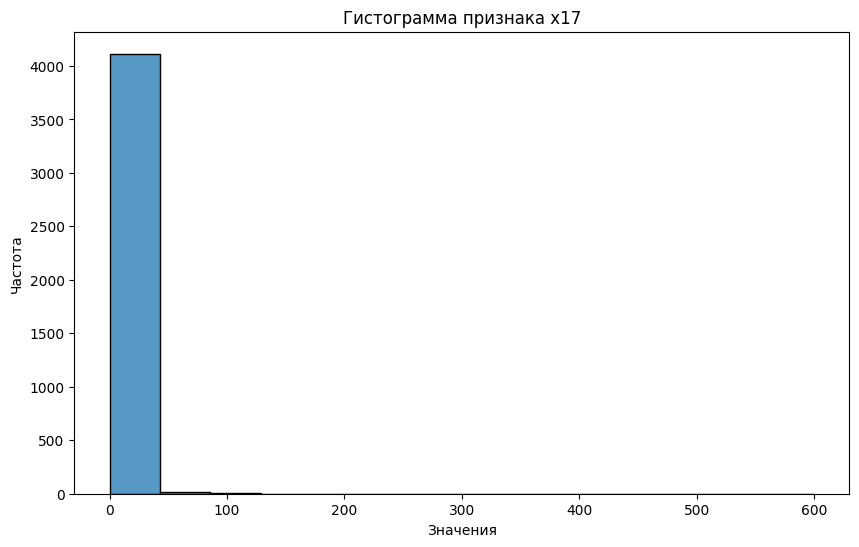

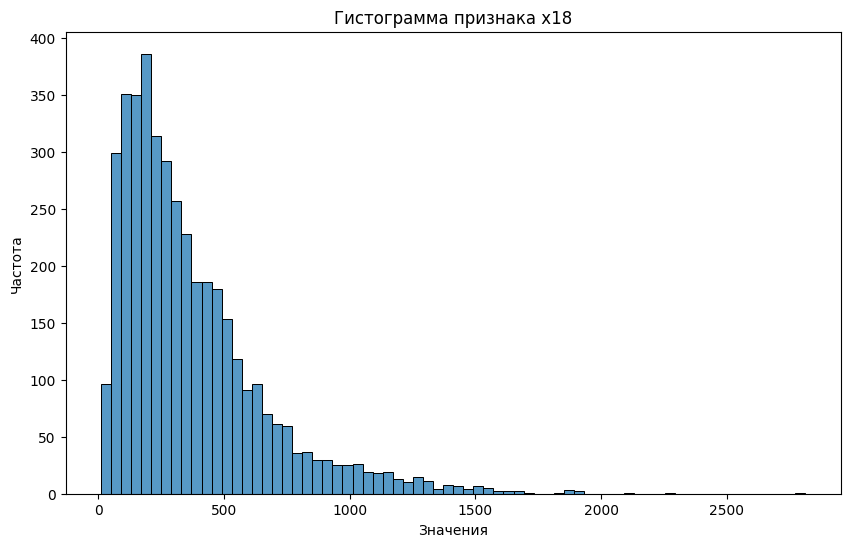

In [57]:
for feature_name in train_data_10.columns:
    if feature_name == 'y':
        continue
    visualize_histogram(train_data_10, feature_name)

In [58]:
freq = {}
for x in train_data_10['x15']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 3033)


In [59]:
freq = {}
for x in train_data_10['x16']:
    if x in freq:
        freq[x] += 1
    else:
        freq[x] = 1
max_item = max(freq.items(), key=lambda k_v: k_v[1])
print(f'Maximum item (key, value): {max_item}')

Maximum item (key, value): (0.0, 3026)


In [60]:
func(train_data_10)

Score: 0.2225


## 11. Удаление признаков признака для 

In [99]:
def delete_2(data):
    data = data.drop(columns=['x1', 'x2', 'x4', 'x5', 'x10', 'x11', 'x15', 'x16', 'x17'])
    return data

In [100]:
train_data_11 = train_data.copy()

In [101]:
train_date_11 = delete_2(train_data_11)

In [102]:
func(train_date_11)

Score: 0.2442


## 12. Объеденим подпункты 2, 3, 5, 7, 9 и 11:

In [113]:
def delete_normalize_x6_x8_x11_x12_and_delete_2(data):
    data = delete(data)
    data = normalize_x6(data)
    data = normalize_x8(data)
    data = normalize_x11(data)
    data = normalize_x12(data)
    data = delete_2(data)
    return data

In [114]:
train_data_12 = train_data.copy()

In [115]:
train_data_12 = delete_normalize_x6_x8_x11_x12_and_delete_2(train_data_12)

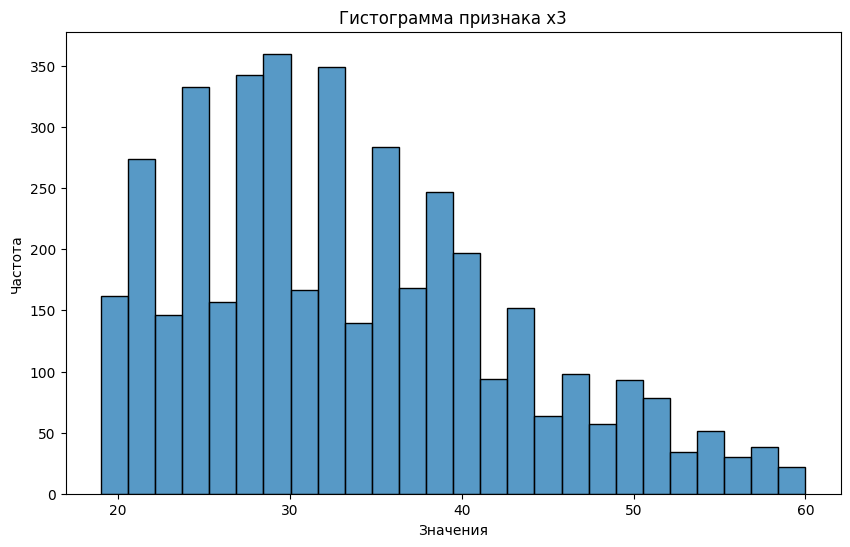

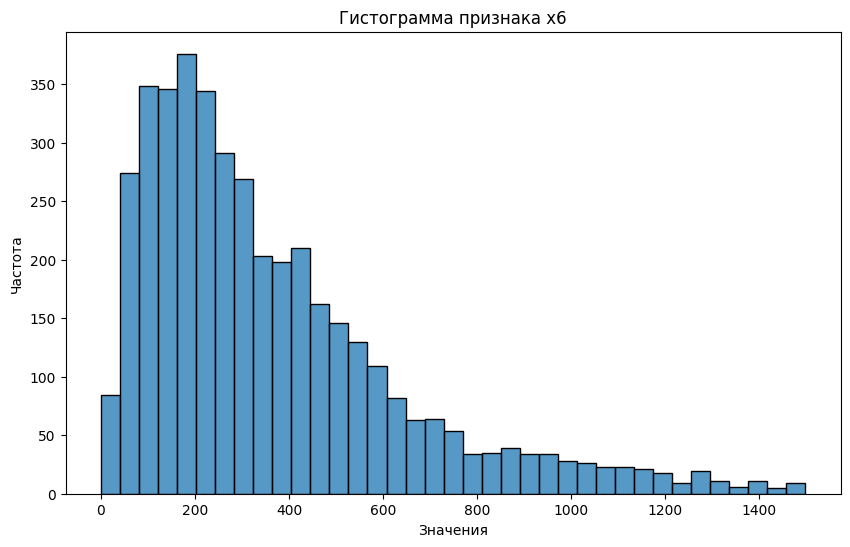

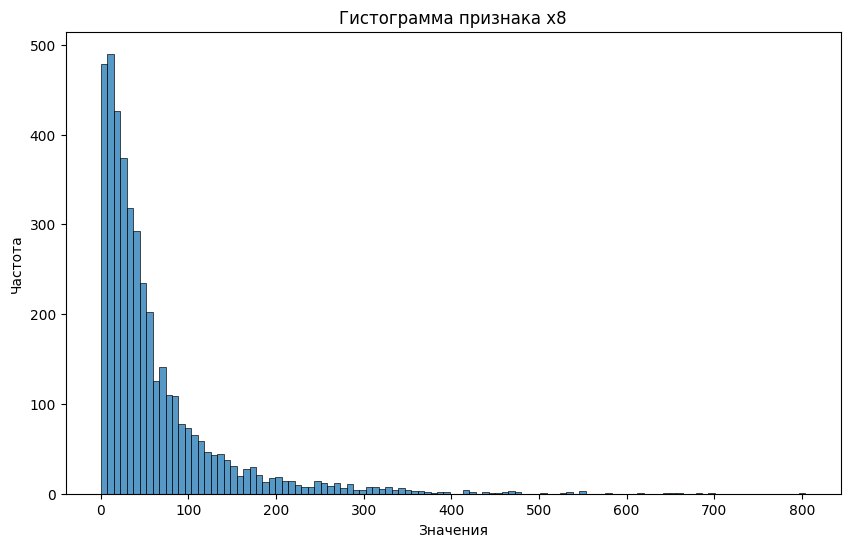

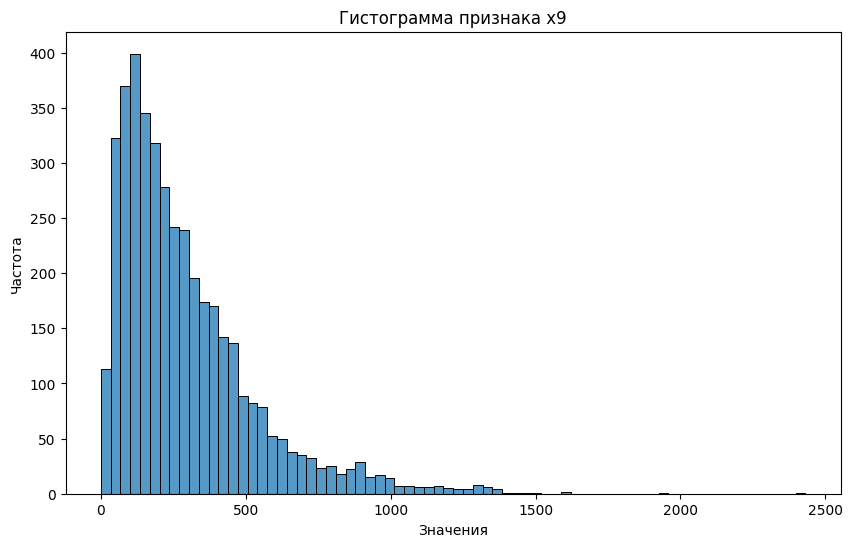

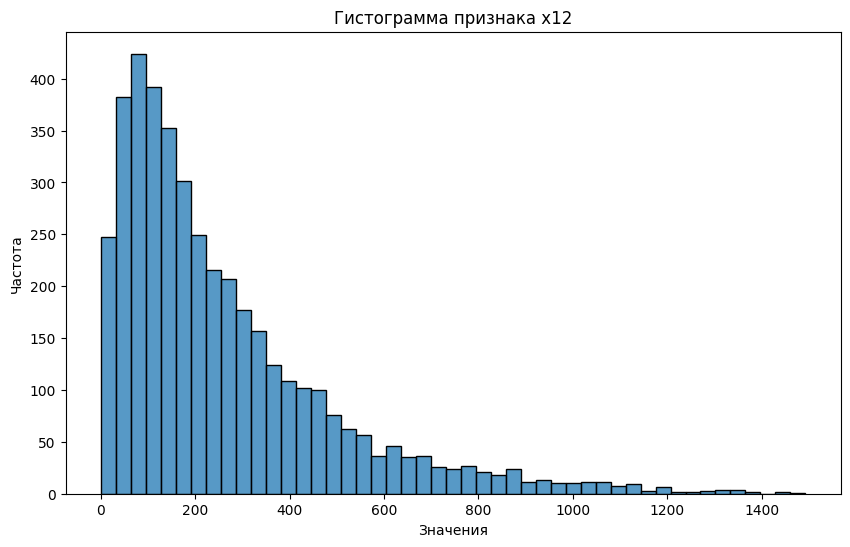

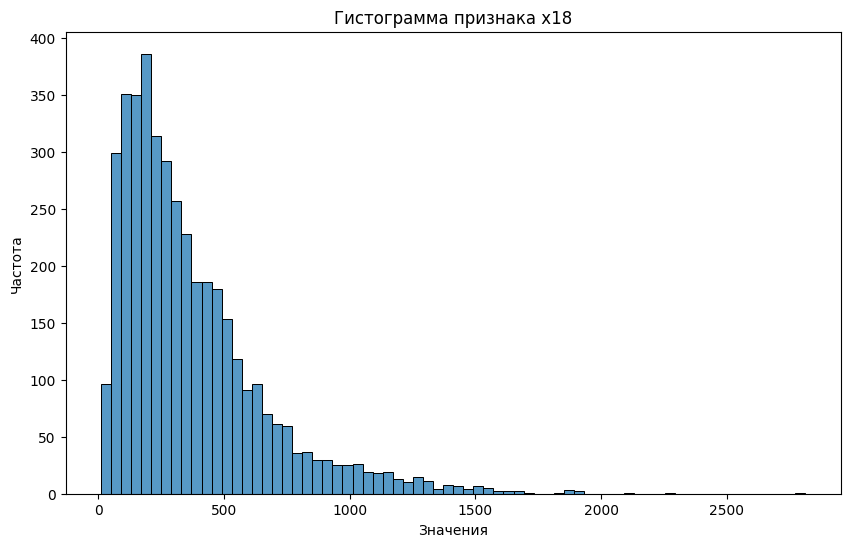

In [116]:
for feature_name in train_data_12.columns:
    if feature_name == 'y':
        continue
    visualize_histogram(train_data_12, feature_name)

In [117]:
func(train_data_12)

Score: 0.2243


In [121]:
train_data_12[['x3', 'x6', 'x8', 'x9', 'x12', 'x18']] = np.log1p(train_data_12[['x3', 'x6', 'x8', 'x9', 'x12', 'x18']])

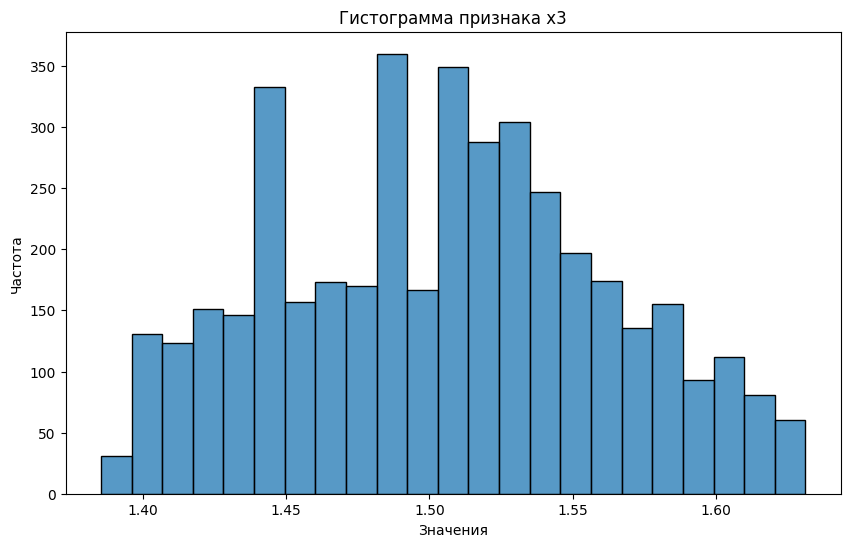

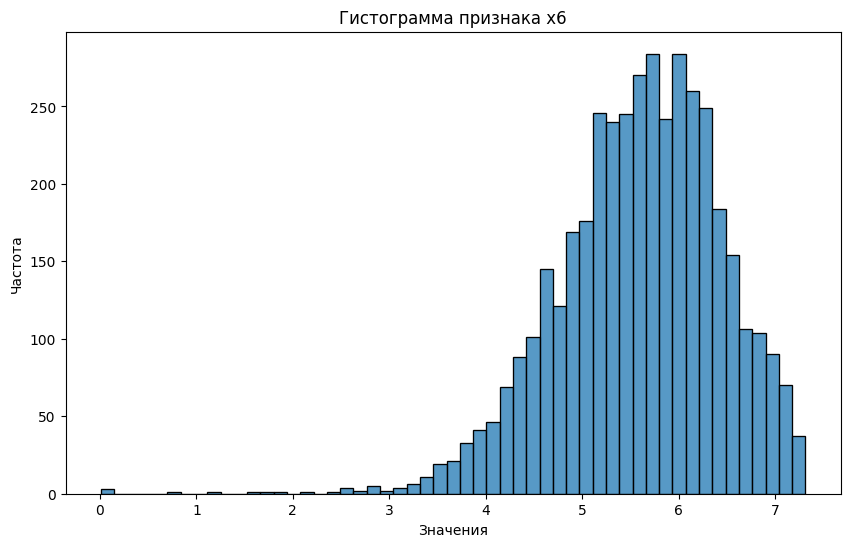

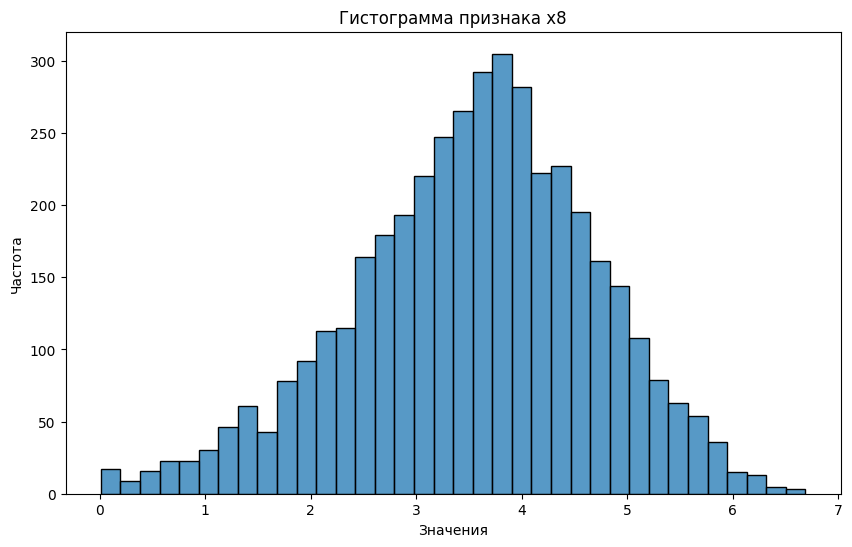

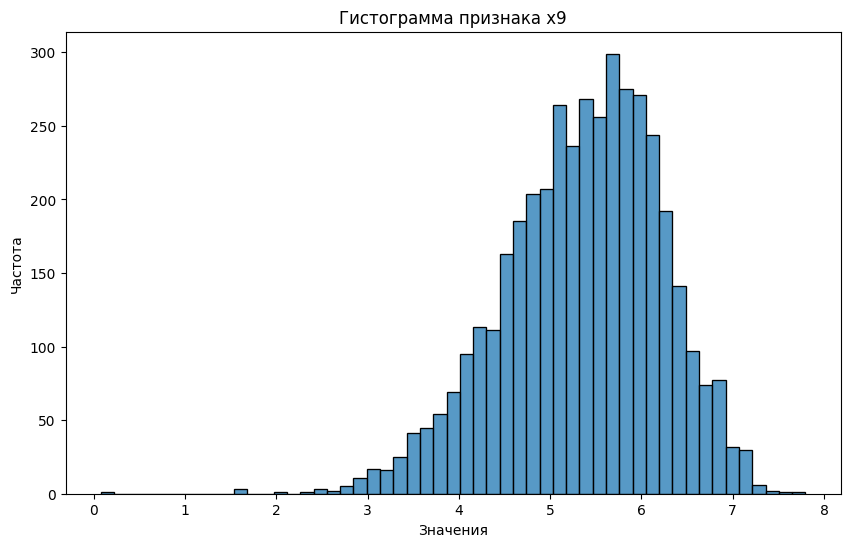

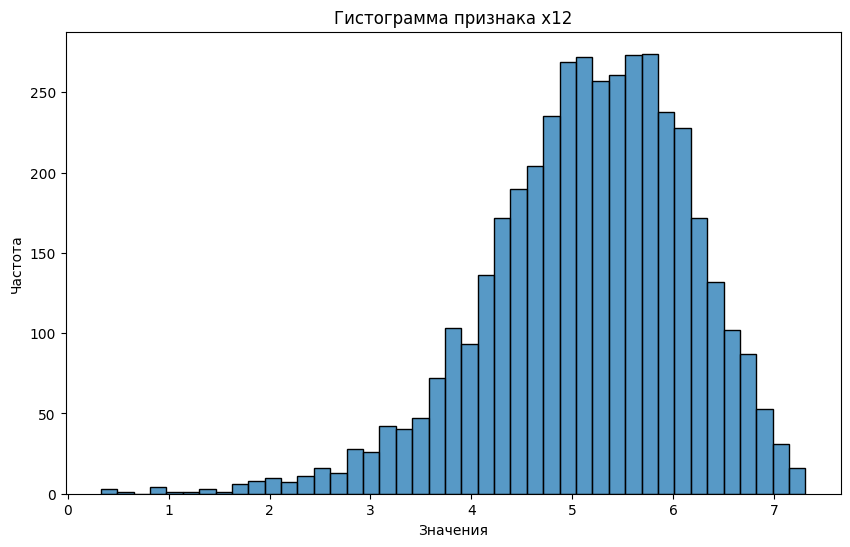

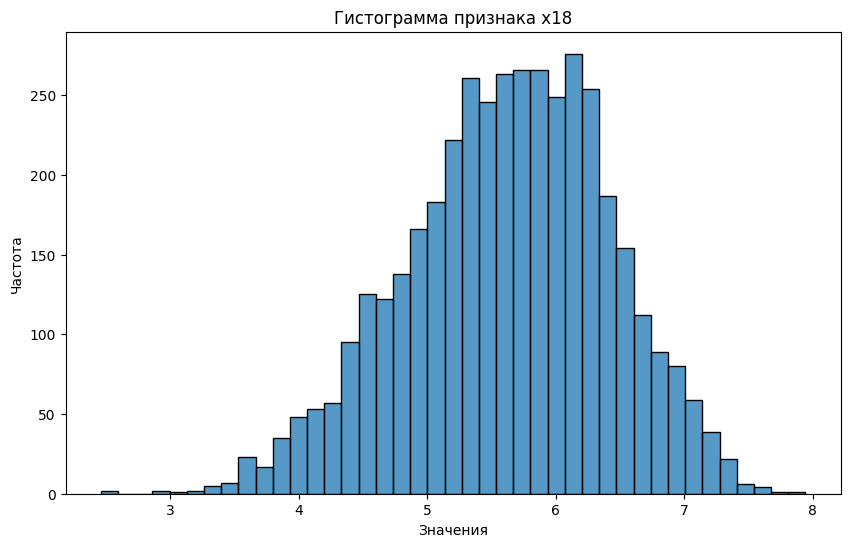

In [122]:
for feature_name in train_data_12.columns:
    if feature_name == 'y':
        continue
    visualize_histogram(train_data_12, feature_name)

In [123]:
func(train_data_12)

Score: 0.3290


# Проверка модели на тестовом наборе

In [124]:
train_path = 'train.csv'
test_path = 'test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [125]:
train_data = train_data.drop(columns=['index'])
test_data = test_data.drop(columns=['index'])

In [126]:
train_data = delete_normalize_x6_x8_x11_and_x12(train_data)
test_data = delete(test_data)

In [127]:
X = train_data.drop(columns=['y'])
Y = train_data['y']

model = M1()
model.fit(X, Y)

Y_test = model.predict(test_data)
answer = pd.DataFrame({'y': Y_test})
answer.to_csv('answer.csv', index=True, index_label='index')